# Document Clustering #

*Based on materials by Brandon Rose, Jacob Eisenstein, and Eun Seo Jo et al.*

Last class, we learned about document classification, which assumes the following setup:

• a training set where you get observations x and labels y;
• a test set where you only get observations x.

But what happens when you don't have labeled data? Is it possible to learn anything? 

This scenario is known as *unsupervised learning,* and we will see that it is very possible to learn about the underlying structure of unlabeled observations. 

### Unsupervised learning: a quick first example ###

One place where unsupervised learning is used is in word sense disambiguation. Here, the goal is to classify each instance of a word, such as bank, into one of these two senses:

• `bank#1`: a financial institution

• `bank#2`: the land bordering a river

It is difficult to obtain sufficient training data for word sense disambiguation, because even a large corpus will contain only a few instances of all but the most common words. 

Is it possible to learn anything about these different senses without labeled data?

Word sense disambiguation is usually performed using feature vectors constructed from the local context of the word to be disambiguated. For example, for the word `bank`, the immediate context might typically include words from one of the following two groups:

1. financial, deposits, credit, lending, capital, markets, regulated, reserve, liquid, assets 

2. land, water, geography, stream, river, flow, deposits, discharge, channel, ecology

Now consider a scatterplot, in which each point is a document containing the word bank: 

![banks](http://lklein.com/wp-content/uploads/2019/10/Screen-Shot-2019-10-30-at-3.06.18-PM.png)

*Image from Jacob Eistenstein, Introduction to Natural Language Processing (MIT Press, 2020)*

Here, the location of the document on the x-axis is the count of words in group 1, and the location on the y-axis is the count for group 2. In such a plot, two “blobs” might emerge, and these blobs correspond to the different senses of bank.


### A second example: document clustering ###

Here’s a scenario more related to our class: 

Suppose you download thousands of news articles, and then make a scatterplot as above. In this hypothetical scatter plot, each point corresponds to a document rather than a word. The x-axis is the frequency of one group of words: hurricane, winds, storm; the y-axis is the frequency of another group of words: election, voters, vote. This time, three blobs might emerge: one for documents that are largely about a hurricane, another for documents largely about a election, and a third for documents about neither topic.

These clumps represent the underlying structure of the data. But the two-dimensional scatter plots we have just discussed are based on groupings of context words, whereas in real scenarios, these word lists are unknown. 

Unsupervised learning applies the same basic idea, but in a high-dimensional space with one dimension for every context word. As with the other high-dimensional models we've explored in this course, the space can’t be directly visualized. But the goal is the same: try to identify the underlying structure of the observed data, such that there are a few clusters of points, each of which is internally coherent. 

**Clustering algorithms** are capable of finding such structure automatically.

## Enter K-Means Clustering ##

Clustering algorithms assign each data point to a discrete cluster, zi ∈ 1, 2, . . . K . One of the best known clustering algorithms is K-means, an iterative algorithm that maintains a cluster assignmetn for each instance, and a central ("mean") location for each cluster. K-means iterates between updates to the assignments and the centers:

1. each instance is placed in the cluster with the closest center;

2. each center is recomputed as the average over points in the cluster.

If you're curious, here is the algorithm that formalizes it:

![k-means](http://lklein.com/wp-content/uploads/2019/10/Screen-Shot-2019-10-30-at-3.27.48-PM.png)

*Image from Jacob Eistenstein, Introduction to Natural Language Processing (MIT Press, 2020)*

**NOTE:** An important property of K-means is that the converged solution depends on the initialization, and a better clustering can sometimes be found simply by re-running the algorithm from a different random starting point.

## Let's get to it! ##

In this example, we're going to use k-means clustering in order to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list), a corpus created by Brandon Rose. See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the corpus.

Let's start with the imports:

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup # remember this one! 
import re # this too! 
from sklearn import feature_extraction

## Corpus Pre-Proccesing ##

Here we go again. Let's pre-process our corpus. 

In [2]:
# import three lists: titles, links, and wikipedia synopses
titles = open('title_list.txt').read().split('\n')

# ensures that only the first 100 are read in
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []

for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    # strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki
    
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [3]:
# now let's get the imdb synopses

synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [4]:
# make a list with the two sets of synopses

synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

# see what one looks like
print(synopses[0])

 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito's godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter's wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito's youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito's godson   Johnny

### For document clustering, some people like to stem first ###

In [5]:
import sys
!{sys.executable} -m pip install textblob # an alternative to spaCy

from textblob import TextBlob

def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

     |████████████████████████████████| 645kB 2.5MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


## Now TF-IDF (again!) 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, 
                                   tokenizer=textblob_tokenizer, ngram_range=(1,3),
                                   min_df=.2, max_df=0.8) #note new params

tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_vectorizer_vectors.shape)

(100, 573)


In [7]:
# get our feature names for future reference 
terms = tfidf_vectorizer.get_feature_names()

In [8]:
# get the first vector out (for the first synopsis) just to see what it looks like (we have done this before)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=terms, columns=["tfidf"])

df.sort_values(by=["tfidf"],ascending=False).head(10)

,tfidf
famili,0.530194
hi father,0.230243
son,0.230040
busi,0.198964
kill,0.197255
father,0.187994
meet,0.185493
murder,0.157412
deal,0.115121
hospit,0.113316


## And on to the K-means clustering

Using our tf-idf vectors, we can now run the k-means clustering algorithm. Remember that K-means initializes with a pre-determined number of clusters. Let's choose 5. 

**NOTE:** In general, there is no method for determining exact value of K, but an accurate estimate can be obtained using the following technique:

One of the metrics that is commonly used to compare results across different values of K is the mean distance between data points and their cluster centroid. Since increasing the number of clusters will always reduce the distance to data points, increasing K will always decrease this metric, to the extreme of reaching zero when K is the same as the number of data points. Thus, this metric cannot be used as the sole target. Instead, mean distance to the centroid as a function of K is plotted and the "elbow point," where the rate of decrease sharply shifts, can be used to roughly determine K.

A number of other techniques exist for validating K, but that's the most common one. 

In any case, back to our clusters:


In [9]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters, n_init=10) # default is also 10, but good to know 

km.fit(tfidf_vectorizer_vectors)

# km.labels_ gives you the cluster assignments
clusters = km.labels_.tolist()

In [10]:
# dump our clusters into a dataframe
films = { 'title': titles, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

film_df = pd.DataFrame(films, columns = ['title', 'cluster', 'genre'])

film_df

,title,cluster,genre
0,The Godfather,3,"[u' Crime', u' Drama']"
1,The Shawshank Redemption,0,"[u' Crime', u' Drama']"
2,Schindler's List,0,"[u' Biography', u' Drama', u' History']"
3,Raging Bull,3,"[u' Biography', u' Drama', u' Sport']"
4,Casablanca,4,"[u' Drama', u' Romance', u' War']"
5,One Flew Over the Cuckoo's Nest,0,[u' Drama']
6,Gone with the Wind,0,"[u' Drama', u' Romance', u' War']"
7,Citizen Kane,3,"[u' Drama', u' Mystery']"
8,The Wizard of Oz,0,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
9,Titanic,2,"[u' Drama', u' Romance']"


In [11]:
# find out how many films are in each cluster
film_df['cluster'].value_counts()

0    46
3    21
2    15
4    10
1     8
Name: cluster, dtype: int64

In [12]:
# find the top terms per cluster

# this orders by the distance of each term from the center
# (cluster_centers_ returns an array of [n_clusters, n_features] )
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster " + str(i) + " top words: ")
    top_terms = ""
   
    for ind in order_centroids[i, :10]:
        top_terms += terms[ind] + ", "
  
    print(top_terms)

Cluster 0 top words: 
kill, war, armi, soldier, home, men, famili, captain, order, command, 
Cluster 1 top words: 
georg, film, marri, danc, perform, sing, famili, love, friend, woman, 
Cluster 2 top words: 
mr, car, john, wife, drive, polic, hi wife, n't, ship, ask, 
Cluster 3 top words: 
father, new york, york, new, famili, brother, hi father, deal, kill, apart, 
Cluster 4 top words: 
polic, kill, car, train, murder, husband, town, arriv, offic, hous, 


In [13]:
# find the top films per cluster    
for i in range(num_clusters):  
    print("Titles in cluster " + str(i) + ": ")
    cluster_titles = ""

    # create new df of only the specific cluster
    # remember boolean selection! 
    cluster_df = film_df[ film_df["cluster"] == i ]
 
    # create series of titles assoc w/ that cluster 
    for title in cluster_df['title']: 
        cluster_titles += title + ", "

    print(cluster_titles + "\n")

Titles in cluster 0: 
The Shawshank Redemption, Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Lawrence of Arabia, Forrest Gump, The Sound of Music, West Side Story, Star Wars, E.T. the Extra-Terrestrial, The Bridge on the River Kwai, Some Like It Hot, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, Gandhi, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Unforgiven, Raiders of the Lost Ark, Rocky, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, Patton, Jaws, Braveheart, The Treasure of the Sierra Madre, Platoon, Dances with Wolves, The Pianist, The Deer Hunter, All Quiet on the Western Front, Mr. Smith Goes to Washington, Out of Africa, Giant, The Grapes of Wrath, Shane, The African Queen, Stagecoach, Mutiny on the Bounty, Wuthering Heights, 

Titles in cluster 1: 
Singin' in the Rain, It's a Wonderful Life, 

# Dimensionality Reduction with T-SNE

You have probably heard of **t-sne** (is it TEA SNEA? or TAE SNAE..)!  This is "newer" dimension reduction method that emphasizes visual convenience. Sometimes PCA (which we have used in the past) can produce overlapping/crowding of similar points. The con of tsne is that it is not as easily interpretable as PCA. It's also non-deterministic -- you'll get different but similar results everytime. But I thought you should play with it since it is widely used in machine learning today.

Example projects: [hip hop](https://pudding.cool/2017/09/hip-hop-words/) and [wikipedia political ideologies](https://genekogan.com/works/wiki-tSNE/)

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

embed = tsne.fit_transform(tfidf_vectorizer_vectors.toarray())
xs, ys = zip(*embed) # we'll use these coords below, after we set up our plot

## Visualizing document clusters

In [19]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4'}

In [20]:
#create data frame that has the result of the t-sne plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) # here's where the coords come in 

#group by cluster
groups = df.groupby('label')

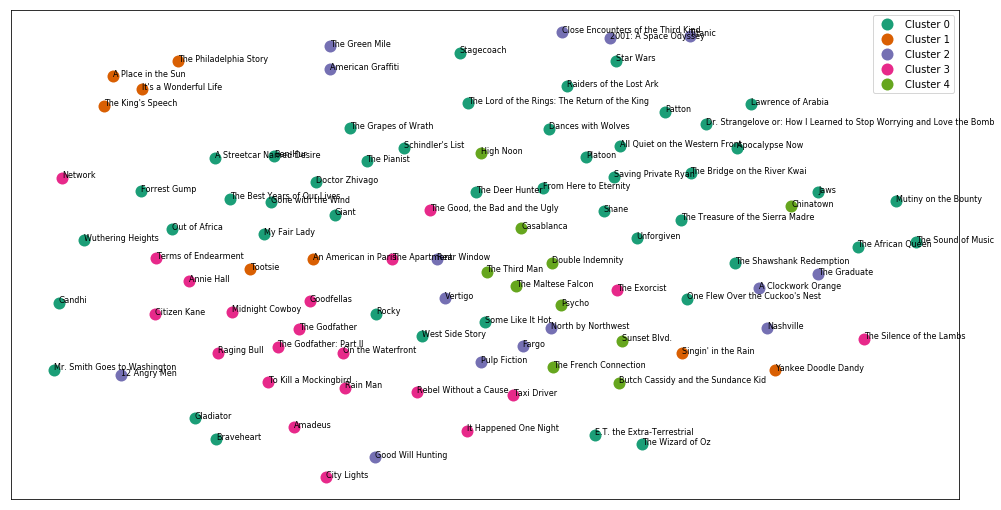

In [22]:
# set up plot
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return 
# the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  
    
plt.show() #show the plot


# Hierarchical document clustering

Here's an example of hierarchical document clustering using Ward's method, which relies on minimum variance. [more here](https://www.statisticshowto.datasciencecentral.com/wards-method/)

First, we need to calculate cosine distance, where dist is defined as 1 - the cosine similarity of each document. 
The cosine similarity is measured against the tf-idf vectors and can be used to generate a measure of 
similarity between each document and the other documents in the corpus (each synopsis among the synopses). (We have seen this before in word2vec's similarity method.

Here, we subtract it from 1 so we can plot it on a euclidian (2-d) plane. 

Note that with "dist" it is possible to evaluate the similarity of any two or more synopses as well.

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_vectorizer_vectors)

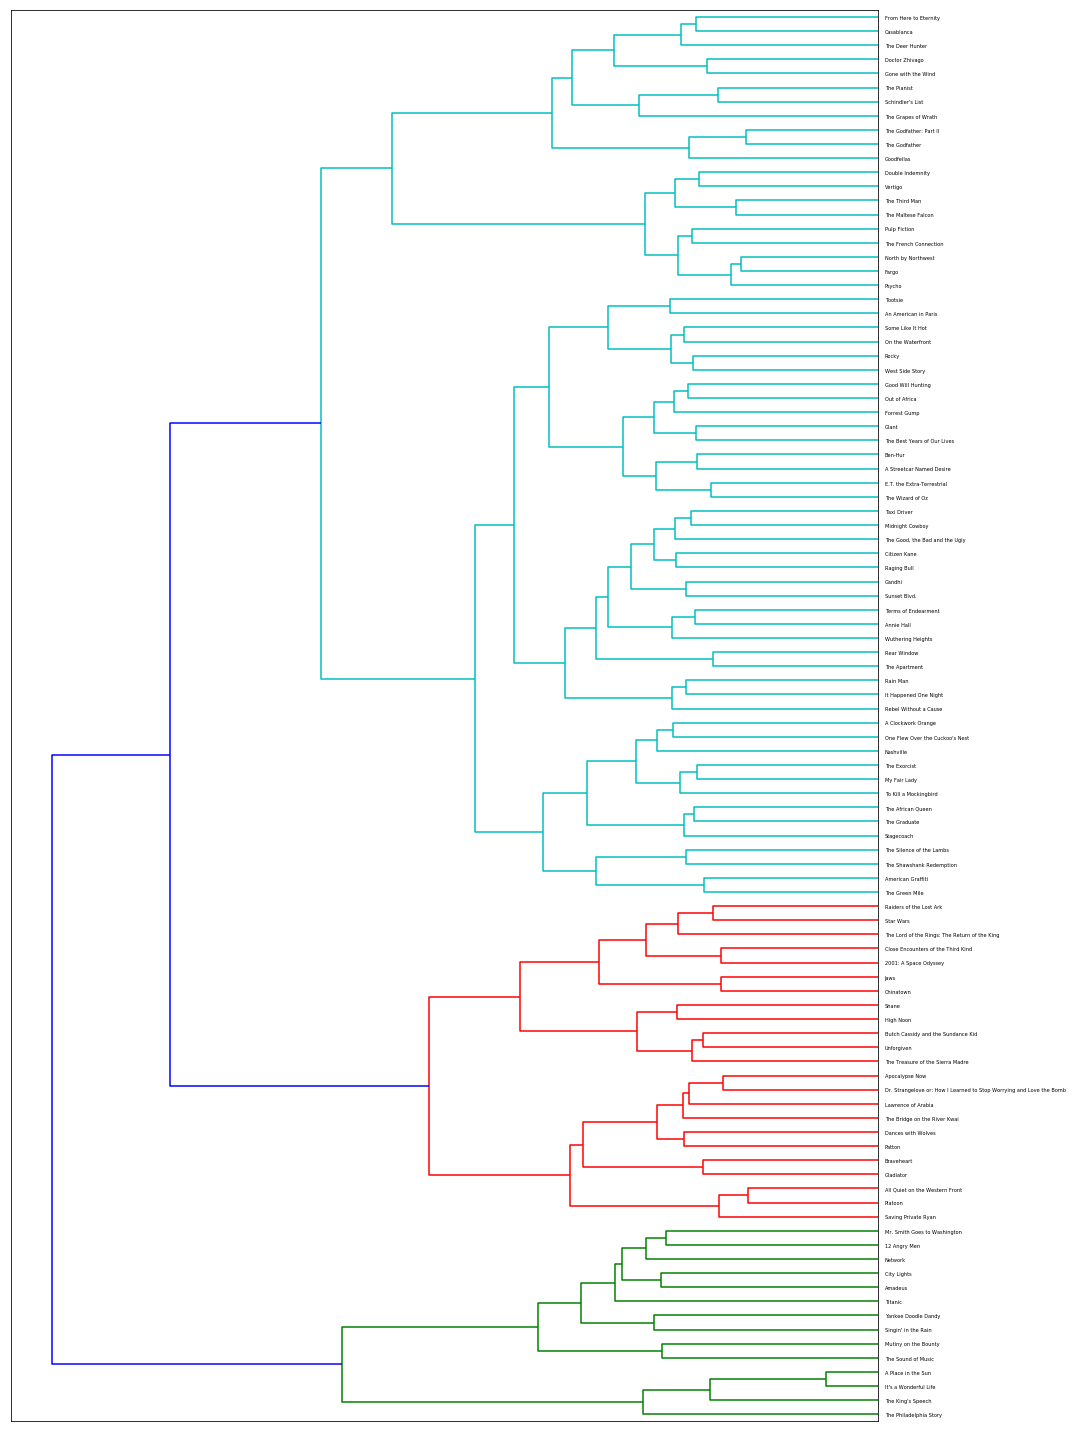

In [27]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.tight_layout() #show plot with tight layout

In [ ]:
plt.close()